('gap distribution from 1-144, total =', 83319)
('gap distribution from 36-144, total =', 68995)


E:\Miniconda2\lib\site-packages\ipykernel\__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Miniconda2\lib\site-packages\ipykernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


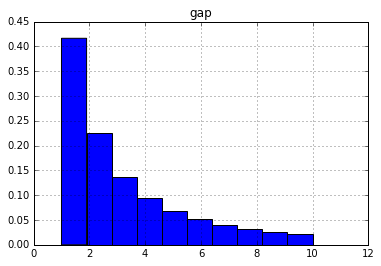

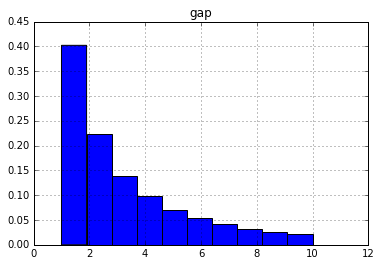

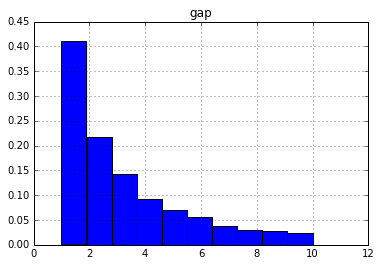

In [14]:
%matplotlib inline
import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt

def is_weekend(day):
    return ((day % 7 == 2) | (day % 7 == 3) | (day == 1))

data = pd.DataFrame.from_csv('training_data_xiaonan_update.csv', index_col=None)
print('gap distribution from 1-144, total =', data.loc[(data['gap']<10)].shape[0] ) 
pd.DataFrame.hist(data.loc[data['gap']<11], column = 'gap', normed=True)

# only consider the time slot to test
print('gap distribution from 36-144, total =', data.loc[(data['gap']<10) & (data['slot'] > 35)].shape[0] ) 
pd.DataFrame.hist(data.loc[(data['gap']<11) & (data['slot'] > 35)], column = 'gap', normed=True)

# show test time-slot distribution
pd.DataFrame.hist(data.loc[(data['gap']<11) & ((data['slot'] % 12 == 10) &(data['slot'] > 40))]\
                  , column = 'gap', normed=True)

grouped = data.groupby([is_weekend(data['day']),  'slot'])
gap_grouped = grouped['gap'].sum().reset_index(name = 'gap_count')
gap_grouped['inc_rate'] = 0.1;
for i in gap_grouped.index:
    if i > 3:
        t = gap_grouped.xs(i)['gap_count'];
        s =  0;
        for j in range(1,4):
            s = s + gap_grouped.xs(i-j)['gap_count']
        s = s*1.0/3.0     
        gap_grouped.set_value(i,'inc_rate', (t-s)*1.0/s )

gap_grouped = gap_grouped.set_index(['day','slot'])

groupedzone = data.groupby(['zone_id'])
gap_zone = groupedzone['gap'].sum().reset_index(name = 'gap_zone')

data = data.loc[data['slot'] > start_timeslot]
data['gap_mean'] = data.apply(lambda x: (x['gap_past1']+x['gap_past2']+x['gap_past3'])/3\
                                       , axis=1)
data['dif_gap'] = data.apply(lambda x: gap_grouped.xs([is_weekend(x['day']), x['slot']])['inc_rate']\
                                        *x['gap_mean'], axis=1)

data = data.merge(gap_zone, how='left', on='zone_id')

In [55]:
#training and evaluation
from sklearn_pandas import DataFrameMapper
import numpy as np
from numpy import matlib
import sklearn.preprocessing, sklearn.decomposition, sklearn.pipeline, sklearn.metrics
from sklearn import cross_validation, linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn import ensemble
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

date_boundary = 7;
start_timeslot =  35;

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.sum(np.abs((y_true - y_pred)*1.0 / y_true))*1.0/((144-start_timeslot)*66*(date_boundary))

def model_train_test(data, features):
    #mapper from panda dataframe to sklearn supported numpy array, instruction: https://pypi.python.org/pypi/sklearn-pandas
    feature_mapper = DataFrameMapper(features)
    target_mapper = DataFrameMapper([(['gap'], None)])

    #remove the data where time slot is 1~3
    crop_data = data.loc[data['slot'] > start_timeslot]
    X_train = feature_mapper.fit_transform(crop_data.loc[crop_data['day'] > date_boundary].copy())
    X_test = feature_mapper.fit_transform(crop_data.loc[crop_data['day'] <= date_boundary].copy())
    y_train = target_mapper.fit_transform(crop_data.loc[crop_data['day'] > date_boundary].copy())
    y_test = target_mapper.fit_transform(crop_data.loc[crop_data['day'] <= date_boundary].copy())
    X_train[:,0] = is_weekend(X_train[:,0])
    X_test[:,0] = is_weekend(X_test[:,0])

    print "training size:{0}, test size:{1}".format(X_train.shape, X_test.shape)

    print "features", feature_mapper.features
    #linear regression with loss function transformed with zone_id
    lm = linear_model.LinearRegression(fit_intercept = False)
    lm.fit(np.divide(X_train, matlib.repmat(y_train, 1,X_train.shape[1])), np.ones((y_train.shape[0], 1)))
    y_pred = lm.predict(X_test)
    print("MAPE for Linear Regression transfromed with zone_id: %.4f"
         % mean_absolute_percentage_error(y_test, y_pred))

    #linear regression with loss function transformed with zone_id, round to int
    lm = linear_model.LinearRegression(fit_intercept = False)
    lm.fit(np.divide(X_train, matlib.repmat(y_train, 1,X_train.shape[1])), np.ones((y_train.shape[0], 1)))
    y_pred = np.round(lm.predict(X_test))
    print("MAPE for Linear Regression transfromed with zone_id and rounded: %.4f"
         % mean_absolute_percentage_error(y_test, y_pred))
    
    #nn
    
    
    
#     k = 3
#     X_train = feature_mapper.fit_transform(crop_data.loc[(crop_data['day'] > date_boundary) & (crop_data['gap']<=k)].copy())
#     y_train = target_mapper.fit_transform(crop_data.loc[(crop_data['day'] > date_boundary) & (crop_data['gap']<=k)].copy())



#     #gradient boosted classifier
#     clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, subsample=1,\
#                                  max_depth=3, random_state=0).fit(X_train, y_train)
#     y_clf = clf.predict(X_test).reshape(y_test.shape[0],1)
#     print("MAPE for GBDT classifier: %.4f"
#          % mean_absolute_percentage_error(y_test, y_clf))


#     #mix model
#     y_mix = (y_clf >= k) * y_pred + y_clf * (y_clf < k)
#     print("MAPE for mix GBDT classifier and linear regression: %.4f"
#          % mean_absolute_percentage_error(y_test, y_mix))

    
    
    
    
#     #feature selection for classification
#     ch2 =  SelectKBest(chi2, k=35)
#     X_train = ch2.fit_transform(X_train, y_train.reshape(y_train.shape[0])>1)
#     X_test = ch2.transform(X_test)

#     #logistic regression
#     logreg = linear_model.LogisticRegression(C=1e5)
#     logreg.fit(X_train, y_train.reshape(y_train.shape[0]) > 1)

#     y_clf = logreg.predict(X_test).reshape(y_test.shape[0],1)
#     y_pred = np.ones((y_test.shape[0], 1)) + y_clf
#     print("MAPE for Logistic Regression: %.4f"
#          % mean_absolute_percentage_error(y_test, y_pred))

#     #svm
#     clf = svm.LinearSVC()
#     clf.fit(X_train, y_train.reshape(y_train.shape[0]) > 1)

#     y_clf = clf.predict(X_test).reshape(y_test.shape[0],1)
#     y_pred = np.ones((y_test.shape[0], 1)) + y_clf
#     print("MAPE for SVM: %.4f"
#          % mean_absolute_percentage_error(y_test, y_pred))
    
    # gradient boost tree
    #params = {'loss': 'ls', 'n_estimators': 50, 'max_depth': 8, 'subsample': 0.7}
    #clf = ensemble.GradientBoostingRegressor(**params)
    #clf.fit(X_train,y_train.reshape(y_train.shape[0]))
    #y_pred = clf.predict(X_test)
    #print("MAPE for gradient boost: %.4f"
    #     % mean_absolute_percentage_error(y_test, y_pred))    

    # #feature selection + linear regression 
    # ch2 =  SelectKBest(chi2, k=90)
    # X_train = ch2.fit_transform(X_train, y_train>1)
    # X_test = ch2.transform(X_test)
    # lm = linear_model.LinearRegression(fit_intercept = False)
    # lm.fit(np.divide(X_train, matlib.repmat(y_train, 1,X_train.shape[1])), np.ones((y_train.shape[0], 1)))
    # y_pred = np.round(lm.predict(X_test))
    # # MAPE
    # print("MAPE for Linear Regression + feature selection: %.4f"
    #      % mean_absolute_percentage_error(y_test, y_pred))

ImportError: cannot import name MLPRegressor

In [50]:
base_features = [(['day', 'dif_gap','gap_zone'], None),
            (['gap_past3', 'gap_past2', 'gap_past1'], None),
          (['request_past1', 'request_past2', 'request_past3'], None),
          (['accept_past1', 'accept_past2', 'accept_past3'], None),          
          (['zone_id'], sklearn.preprocessing.OneHotEncoder(sparse=False))]
model_train_test(data, base_features)

training size:(58005L, 78L), test size:(28395L, 78L)
features [(['day', 'dif_gap', 'gap_zone'], None), (['gap_past3', 'gap_past2', 'gap_past1'], None), (['request_past1', 'request_past2', 'request_past3'], None), (['accept_past1', 'accept_past2', 'accept_past3'], None), (['zone_id'], OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=False))]
MAPE for Linear Regression transfromed with zone_id: 0.2627
MAPE for Linear Regression transfromed with zone_id and rounded: 0.2511


In [51]:
features=base_features + [(['congestion_1_past1', 'congestion_2_past1', 'congestion_3_past1', 'congestion_4_past1'], sklearn.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0)),
(['congestion_1_past2', 'congestion_2_past2', 'congestion_3_past2', 'congestion_4_past2'], sklearn.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0)),
(['congestion_1_past3', 'congestion_2_past3', 'congestion_3_past3', 'congestion_4_past3'], sklearn.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0))]
model_train_test(data, features)

training size:(58005L, 90L), test size:(28395L, 90L)
features [(['day', 'dif_gap', 'gap_zone'], None), (['gap_past3', 'gap_past2', 'gap_past1'], None), (['request_past1', 'request_past2', 'request_past3'], None), (['accept_past1', 'accept_past2', 'accept_past3'], None), (['zone_id'], OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=False)), (['congestion_1_past1', 'congestion_2_past1', 'congestion_3_past1', 'congestion_4_past1'], Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0)), (['congestion_1_past2', 'congestion_2_past2', 'congestion_3_past2', 'congestion_4_past2'], Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0)), (['congestion_1_past3', 'congestion_2_past3', 'congestion_3_past3', 'congestion_4_past3'], Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0))]
MAPE for Linear Regression transfromed with zone_id: 0.2623
MAPE for Linear Regression tr

In [52]:
features = features + [(['weather_past1','weather_past2', 'weather_past3'], sklearn.preprocessing.OneHotEncoder(sparse=False)),
                      (['temperature_past1','temperature_past2','temperature_past3'], sklearn.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0)),
                      (['pm25_past1','pm25_past2','pm25_past3'], sklearn.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0))]
model_train_test(data, features)

training size:(58005L, 117L), test size:(28395L, 117L)
features [(['day', 'dif_gap', 'gap_zone'], None), (['gap_past3', 'gap_past2', 'gap_past1'], None), (['request_past1', 'request_past2', 'request_past3'], None), (['accept_past1', 'accept_past2', 'accept_past3'], None), (['zone_id'], OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=False)), (['congestion_1_past1', 'congestion_2_past1', 'congestion_3_past1', 'congestion_4_past1'], Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0)), (['congestion_1_past2', 'congestion_2_past2', 'congestion_3_past2', 'congestion_4_past2'], Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0)), (['congestion_1_past3', 'congestion_2_past3', 'congestion_3_past3', 'congestion_4_past3'], Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0)), (['weather_past1', 'weather_past2', 'weather_past3'], OneHotEncoder(categorical_feature

In [53]:
# output result
def LoadClusterMap(filename):
    """
    Build a cluster dictionary with key district hash and value zone id from reading filename.
    """
    pattern = re.compile("[^\t]+")
    with open(filename) as f:
        lines = f.read().splitlines()

    cluster_map = {}
    for line in lines:
        keyvalue = pattern.findall(line)
        cluster_map[keyvalue[0]]=keyvalue[1]

    return cluster_map 

def GetDay(date):
    """Convert string date to date
    """
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    
    return dt.day

cluster_map =  LoadClusterMap('../season_1/test_set_2/cluster_map/cluster_map')

test_data = pd.DataFrame.from_csv('test_data.csv', index_col=None)

with open('../season_1/test_set_2/read_me_2.txt') as f:
    lines = f.read().splitlines()[1:]

test_result = pd.DataFrame()
with open('testresult.csv', 'w') as f:
    for line in lines:
        date = line[0:10]
        slot = int(line[11:])
        data_oneday = test_data.loc[(test_data['date']==date) & (test_data['time_slot']==slot)]
        test_x = feature_mapper.fit_transform(data_oneday.copy())
        y_pred = np.round(lm.predict(test_x))
        abs_index = 0
        for i in data_oneday.index:
            test_result = test_result.append(pd.DataFrame([[data_oneday.ix[i]['zone_id'], line, y_pred[abs_index,0]]]))
            abs_index = abs_index + 1

    test_result.to_csv(f, header=False, index=False)

NameError: name 'feature_mapper' is not defined

In [56]:
def grad(param, x):
    g = 0;
    for i in range(0, x.shape[0]):
        if np.dot(param, x[i,:]) > 1:
            g = g+x
        else:
            g = g-x
    return g
            
                    


In [54]:
# experiment block for python gramma


IndexError: too many indices for array